In [140]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
from sqlalchemy import create_engine # needed for DB connection.

df = pd.read_csv("surgical_case_durations.csv", sep=";", encoding="ISO-8859-1")
df.dropna(subset=['Benadering', 'Geslacht', 'AF', 'CCS', 'NYHA', 'Euroscore1'], how='all', inplace=True)
df.dropna(subset=['Operatieduur'], how='all', inplace=True)
print(df.shape)


(3530, 36)


In [141]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [142]:
surgery = df[["Operatietype", "Chirurg", "Anesthesioloog", "Benadering", "OK", "Casustype", "Dagdeel",
             "Aantal anastomosen", "HLM", "Geplande operatieduur", "Operatieduur", "Ziekenhuis ligduur", "IC ligduur",
             "Leeftijd", "Geslacht", "AF", "Chronische longziekte", "Extracardiale vaatpathie",
             "Actieve endocarditis", "Hypertensie", "Pulmonale hypertensie", "Slechte mobiliteit", "Hypercholesterolemie",
             "Perifeer vaatlijden", "Linker ventrikel functie", "Nierfunctie", "BMI", "DM", "Eerdere hartchirurgie",
            "Kritische preoperatieve status", "Myocard infact <90 dagen", "Aorta chirurgie", "Euroscore1", "CCS", "NYHA"]]
surgery = surgery.rename(columns={"Operatietype": "surgery_type", "Chirurg": "surgeon", "Benadering": "surgical_approach",
                                  "Anesthesioloog": "anesthesiologist", "OK": "operation_room", "Casustype": "urgency",
                                  "Dagdeel": "time_of_day", "Aantal anastomosen": "bypasses_amount", "HLM" : "cardiopulmonary_bypass_use",
                                  "Geplande operatieduur" : "planned_surgery_duration", "Operatieduur" : "surgery_duration",
                                  "Ziekenhuis ligduur":"hospital_days", "IC ligduur":"IC days", "Leeftijd" : "patient_age", 
                                  "Geslacht": "patient_gender", "AF": "atrial_fibrillation", "Chronische longziekte": "chronic_lung_disease", 
                                  "Extracardiale vaatpathie": "extracardial_arteriopathy", "Actieve endocarditis":"active_endocarditis",
                                  "Hypertensie" : "hypertension", "Pulmonale hypertensie": "pulmonary_hypertension",
                                  "Slechte mobiliteit" : "poor_mobility", "Hypercholesterolemie": "hypercholesterolemia", 
                                  "Perifeer vaatlijden": "peripherial_vascular_disease", "Linker ventrikel functie": "left_ventricle", 
                                  "Nierfunctie": "renal_function", "DM" : "diabetes_mellitus", "Eerdere hartchirurgie": "previous_heart_surgery", 
                                  "Kritische preoperatieve status": "critical_pre_or_state", "Myocard infact <90 dagen": "mycordial_infarction", 
                                  "Aorta chirurgie": "aortic_surgery"})
surgery = surgery.drop_duplicates(ignore_index=True, keep="last")
surgery["surgeryid"] = surgery.reset_index().index

In [144]:
surgery['surgical_approach'] = surgery['surgical_approach'].replace({'Volledige sternotomie':'Full sternotomy',
                                                                     'Antero lateraal links' : 'Left antero lateral',
                                                                     'Antero lateraal rechts' : 'Right antero lateral',
                                                                     'Postero lateraal links' : 'Left postero lateral',
                                                                     'Postero lateraal rechts' : 'Right postero lateral',
                                                                     'Partiële sternotomie' : 'Partial sternotomy',
                                                                     'Dwarse sternotomie' : 'Other approaches',
                                                                     'Parasternaal rechts' : 'Other approaches',
                                                                     'Parasternaal links' : 'Other approaches',
                                                                     'Xiphoidaal' : 'Other approaches'})
value_counts = surgery['surgery_type'].value_counts()

# Create a mapping of values to change
values_to_change = value_counts[value_counts < 20].index

# Use the apply method to change values based on the condition
surgery['surgery_type'] = surgery['surgery_type'].apply(lambda x: 'Other types' if x in values_to_change else x)
surgery['surgery_type'] = surgery['surgery_type'].replace({'Lobectomie of segmentresectie':'Lobectomy or segment resection',
                                                           'Mediastinoscopie' : 'Mediastinoscopy',
                                                           'VATS Boxlaesie' : 'video assisted thoracic surgery'})
surgery['surgery_type'].fillna('Other types', inplace=True)
surgery['surgical_approach'].fillna('Other approaches', inplace=True)
surgery['urgency'] = surgery['urgency'].replace({'Electief':'Elective',
                                                 'Acuut < 30 minuten' : 'Acute (< 30 minutes)',
                                                 'Spoed' : 'Acute',
                                                 'Spoed < 24 uur' : 'Emergency (< 24 hours)',
                                                 'Spoed < 5 uur' : 'Acute (< 5 hours)'})

surgery['urgency'].fillna('Unknown', inplace=True)
surgery['time_of_day'] = surgery['time_of_day'].replace({'Ochtend':'Morning',
                                                         'Middag' : 'Afternoon',
                                                         'Nacht' : 'Evening and night',
                                                         'Avond' : 'Evening and night',})
surgery['bypasses_amount'].fillna('0.00', inplace=True)
surgery['bypasses_amount'] = surgery['bypasses_amount'].astype(float)
surgery['bypasses_amount'] = surgery['bypasses_amount'].astype(int)
surgery['cardiopulmonary_bypass_use'] = surgery['cardiopulmonary_bypass_use'].replace({'J':'Y'})

surgery["latestatus"] = np.where(surgery["surgery_duration"]>surgery["planned_surgery_duration"], "Late", "Not Late")
surgery["time_difference"] = abs(surgery["surgery_duration"]-surgery["planned_surgery_duration"])
conditions  = [ surgery["time_difference"] >= 120, (surgery["time_difference"] < 120) & (surgery["time_difference"]>= 60), 
               (surgery["time_difference"] < 60) & (surgery["time_difference"]>= 30), (surgery["time_difference"]< 30)  ]
choices     = [ "more than 2 hours", 'more than 1 hour', 'more than 30 minutes', 'less than 30 minutes' ]
surgery["time_difference"] = np.select(conditions, choices, default=np.nan)
#modify value
#surgery['BMI'] = surgery['BMI'].astype(float)
surgery['patient_gender'] = surgery['patient_gender'].replace({'V':'F'})
surgery['atrial_fibrillation'] = surgery['atrial_fibrillation'].replace({'J':'Y'})
surgery['chronic_lung_disease'] = surgery['chronic_lung_disease'].replace({'J':'Y'})
surgery['active_endocarditis'] = surgery['active_endocarditis'].replace({'J':'Y'})
surgery['poor_mobility'] = surgery['poor_mobility'].replace({'J':'Y'})
surgery['hypertension'] = surgery['hypertension'].replace({'J':'Y'})
surgery['diabetes_mellitus'] = surgery['diabetes_mellitus'].replace({'J':'Y'})
surgery['peripherial_vascular_disease'] = surgery['peripherial_vascular_disease'].replace({'J':'Y'})
surgery['hypercholesterolemia'] = surgery['hypercholesterolemia'].replace({'J':'Y'})
surgery['extracardial_arteriopathy'] = surgery['extracardial_arteriopathy'].replace({'J':'Y'})
surgery['critical_pre_or_state'] = surgery['critical_pre_or_state'].replace({'J':'Y'})
surgery['aortic_surgery'] = surgery['aortic_surgery'].replace({'J':'Y'})
surgery['mycordial_infarction'] = surgery['mycordial_infarction'].replace({'J':'Y'})
surgery['pulmonary_hypertension'] = surgery['pulmonary_hypertension'].replace({'Normaal':'Normal',
                                                                               'Matig' : 'Moderate',
                                                                               'Ernstig' : 'Severe'})
surgery['left_ventricle'] = surgery['left_ventricle'].replace({'Goed':'Good',
                                                               'Matig' : 'Moderate',
                                                               'Slecht' : 'Poor',
                                                               'Heel Slecht' : 'Very Poor'})
surgery['renal_function'] = surgery['renal_function'].replace({'Normaal':'Normal',
                                                               'Matig' : 'Moderate',
                                                               'Slecht' : 'Poor'})

surgery['Euroscore1'] = surgery['Euroscore1'].str.replace(',', '.').astype(float)
surgery['patient_age']=surgery['patient_age'].fillna(surgery['patient_age'].mean())
print(surgery.shape)
surgery.head()

(3530, 38)


,surgery_type,surgeon,anesthesiologist,surgical_approach,operation_room,urgency,time_of_day,bypasses_amount,cardiopulmonary_bypass_use,planned_surgery_duration,...,previous_heart_surgery,critical_pre_or_state,mycordial_infarction,aortic_surgery,Euroscore1,CCS,NYHA,surgeryid,latestatus,time_difference
0,Other types,"4,00","8,00",Full sternotomy,TOK1,Elective,Morning,0,N,229.0,...,N,N,N,Y,44.79,0.0,2.0,0,Not Late,more than 30 minutes
1,Other types,"7,00","6,00",Full sternotomy,TOK2,Elective,Afternoon,0,N,140.0,...,N,N,N,Y,12.16,2.0,1.0,1,Late,more than 30 minutes
2,Other types,"1,00","7,00",Full sternotomy,TOK1,Acute,Morning,0,N,180.0,...,N,N,N,Y,27.38,4.0,4.0,2,Late,less than 30 minutes
3,Other types,"4,00","10,00",Full sternotomy,TOK3,Elective,Morning,0,N,241.0,...,N,N,N,Y,9.78,0.0,1.0,3,Not Late,less than 30 minutes
4,Other types,"3,00","15,00",Full sternotomy,TOK2,Elective,Morning,0,Y,240.0,...,N,N,N,Y,9.76,0.0,1.0,4,Late,less than 30 minutes


In [241]:
X = surgery.loc[:, ["surgery_type", "surgeon", "anesthesiologist", "surgical_approach", "operation_room", "urgency", "time_of_day",
                    "bypasses_amount", "cardiopulmonary_bypass_use", "patient_age", "patient_gender", "atrial_fibrillation", 
                    "chronic_lung_disease", "extracardial_arteriopathy", "active_endocarditis", "hypertension", 
                    "pulmonary_hypertension", "poor_mobility", "hypercholesterolemia", "peripherial_vascular_disease", 
                    "diabetes_mellitus", "previous_heart_surgery", "critical_pre_or_state", "mycordial_infarction", 
                    "Euroscore1"]]
y = surgery['surgery_duration']

In [242]:
# creating dummy variables for categorical variables
surgery_categorical = X.select_dtypes(include=['object'])
surgery_categorical.head()


# convert into dummies
surgery_dummies = pd.get_dummies(surgery_categorical, drop_first=True)
surgery_dummies.head()


# drop categorical variables 
X = X.drop(list(surgery_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, surgery_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [243]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [256]:

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.6,
                                                    test_size = 0.4, random_state=40)

In [266]:
from sklearn.svm import SVR
model = SVR(kernel='linear', C=1.0, epsilon=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 67.24582359752513


In [265]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 68.50698474953816


In [258]:
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

RMSE: 68.35149478522618


In [244]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.345393,0.083303,0.002241,0.000404,2,{'n_features_to_select': 2},0.175727,0.198069,0.224755,0.207769,...,0.194109,0.021782,22,0.201988,0.195833,0.190353,0.192705,0.203442,0.196864,0.005105
1,0.237505,0.000480,0.001614,0.000106,3,{'n_features_to_select': 3},0.189256,0.209532,0.228356,0.210490,...,0.199613,0.023174,20,0.206565,0.201040,0.197659,0.200301,0.212359,0.203585,0.005258
2,0.236434,0.000576,0.001537,0.000025,4,{'n_features_to_select': 4},0.188811,0.209193,0.228154,0.209973,...,0.199213,0.023255,21,0.206743,0.201091,0.197780,0.200486,0.212423,0.203705,0.005245
3,0.284079,0.024705,0.001564,0.000006,5,{'n_features_to_select': 5},0.190078,0.212013,0.227535,0.213395,...,0.200472,0.023801,19,0.208138,0.202134,0.199566,0.201229,0.214322,0.205078,0.005453
4,0.295590,0.000400,0.001572,0.000055,6,{'n_features_to_select': 6},0.238072,0.225974,0.225523,0.247611,...,0.225206,0.019950,18,0.239130,0.242230,0.225668,0.236011,0.250285,0.238665,0.008049


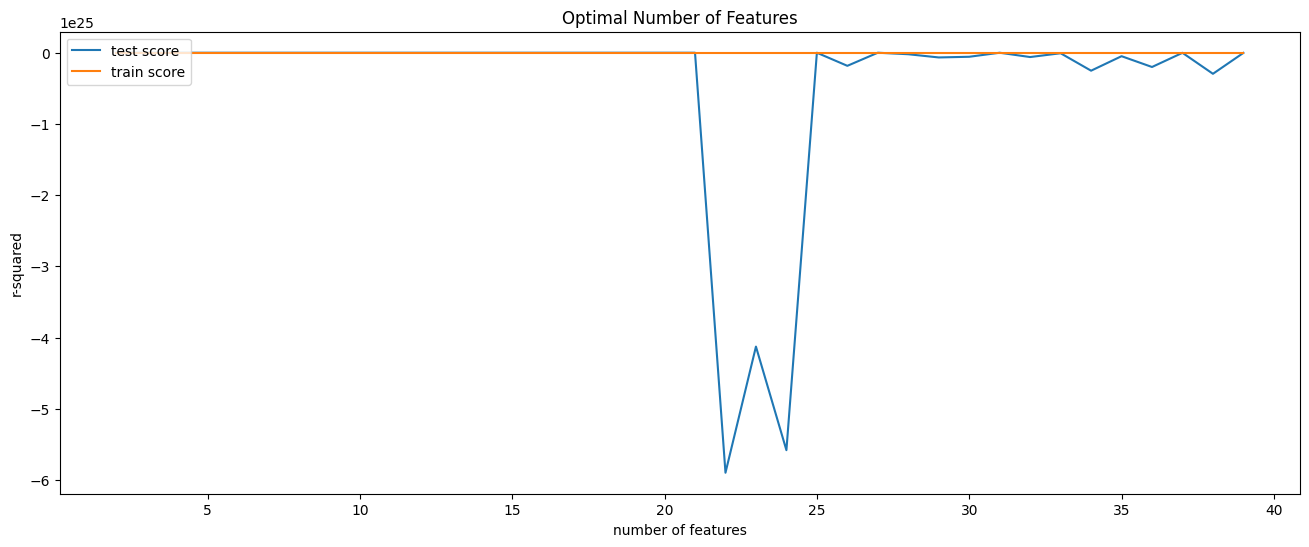

In [245]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [263]:
y_pred = model_cv.predict(X_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

[300.55844885  93.31944301 226.34981348 ... 251.29106682 146.78238068
 260.13551398]
RMSE: 66.6000652142912


In [262]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
#mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(surgery["surgery_duration"], surgery["planned_surgery_duration"])
#mse = mean_squared_error(surgery["surgery_duration"], surgery["planned_surgery_duration"])
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

MSE: 4361.910573321256
RMSE: 66.0447618916236
R-squared: 0.37488783121421587


In [218]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have preprocessed data in X_train, y_train, X_test, and y_test

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Regression task, so no activation function

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the testing data
mse = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

2023-10-26 00:58:13.246371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 00:58:13.433900: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 00:58:14.126291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-26 00:58:14.126377

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
X = surgery.loc[:, ["surgery_type", "surgeon", "anesthesiologist", "surgical_approach", "operation_room", "urgency", "time_of_day",
                    "bypasses_amount", "cardiopulmonary_bypass_use", "patient_age", "patient_gender", "atrial_fibrillation", 
                    "chronic_lung_disease", "extracardial_arteriopathy", "active_endocarditis", "hypertension", 
                    "pulmonary_hypertension", "poor_mobility", "hypercholesterolemia", "peripherial_vascular_disease", 
                    "diabetes_mellitus", "previous_heart_surgery", "critical_pre_or_state", "mycordial_infarction", 
                    "Euroscore1"]]
y = surgery['surgery_duration']